In [69]:
# import packages

In [6]:
import numpy as np
import pandas as pd
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load ------------------------------------------
data = pd.read_csv("data/500000_heavyrate.csv")

# Data pre-process

In [13]:
#drop data
data.drop(['startkilo', 'endkilo', 'year', 'date', 'starttime', 'endtime'], axis=1, inplace=True)
# Since the values of feature "speed limit" are all the same, we drop the feature
data.drop(['speedlimit'], axis=1, inplace=True)
data.drop(['pavement', 'cement', 'remark', 'one'], axis=1, inplace=True)
print(data.columns)

Index(['index', 'startTime_millionSec', 'endTime_millionSec', 'crash', 'lane',
       'minlane', 'addlane', 'totalwidth', 'lanewidth', 'inshoulder',
       'outshoulder', 'upslope', 'downslope', 'upslopelength',
       'downslopelength', 'maxupslope', 'maxdownslope', 'curvelength',
       'minradiuslength', 'minradius', 'continuouscurve', 'interchange',
       'tunnellength', 'tunnelin', 'tunnelout', 'shouderoallow', 'camera',
       'service', 'windspeed', 'rain', 'Var_windspeed', 'Var_rain', 'volume_S',
       'volume_L', 'volume_T', 'volume', 'PCU', 'Speed_volume', 'Speed_PCU',
       'heavy_rate', 'Var_volume', 'Var_PCU', 'Var_Speed_volume',
       'Var_Speed_PCU'],
      dtype='object')


In [14]:
#drop data
data.drop(['upslope', 'downslope', 'minradiuslength', 
           'Var_windspeed', 'Var_rain', 'Var_volume', 
           'Var_PCU', 'Var_Speed_volume', 'Var_Speed_PCU'], axis=1, inplace=True)

In [15]:
print(data.dtypes)

index                     int64
startTime_millionSec      int64
endTime_millionSec        int64
crash                     int64
lane                      int64
minlane                   int64
addlane                   int64
totalwidth              float64
lanewidth               float64
inshoulder              float64
outshoulder             float64
upslopelength             int64
downslopelength           int64
maxupslope              float64
maxdownslope            float64
curvelength               int64
minradius                 int64
continuouscurve           int64
interchange               int64
tunnellength              int64
tunnelin                  int64
tunnelout                 int64
shouderoallow             int64
camera                    int64
service                   int64
windspeed                 int64
rain                      int64
volume_S                  int64
volume_L                  int64
volume_T                  int64
volume                    int64
PCU     

# replace crash values

### convert crash values to 1

In [16]:
# replace crash values
## convert crash values to 1
data.loc[data["crash"] >= 1, "crash"] = 1 

### data['rain'] has many non-numeric values: "&", try to fix them

In [17]:
# data['rain'] has many non-numeric values: "&", try to fix them
data['rain'] = pd.to_numeric(data['rain'], errors='coerce').fillna(0, downcast='float')
data['windspeed'] = pd.to_numeric(data['windspeed'], errors='coerce').fillna(0, downcast='float')
data['Speed_volume'] = pd.to_numeric(data['Speed_volume'], errors='coerce').fillna(0, downcast='float')
data['Speed_PCU'] = pd.to_numeric(data['Speed_PCU'], errors='coerce').fillna(0, downcast='float')
data['heavy_rate'] = pd.to_numeric(data['heavy_rate'], errors='coerce').fillna(0, downcast='float')

print(data.dtypes)

index                     int64
startTime_millionSec      int64
endTime_millionSec        int64
crash                     int64
lane                      int64
minlane                   int64
addlane                   int64
totalwidth              float64
lanewidth               float64
inshoulder              float64
outshoulder             float64
upslopelength             int64
downslopelength           int64
maxupslope              float64
maxdownslope            float64
curvelength               int64
minradius                 int64
continuouscurve           int64
interchange               int64
tunnellength              int64
tunnelin                  int64
tunnelout                 int64
shouderoallow             int64
camera                    int64
service                   int64
windspeed                 int64
rain                      int64
volume_S                  int64
volume_L                  int64
volume_T                  int64
volume                    int64
PCU     

### Convert to categorial type..................

In [18]:
#Convert to categorial type..................
data["crash"] = data["crash"].astype("category")
data["minlane"] = data["minlane"].astype("category")
data["addlane"] = data["addlane"].astype("category")
data["continuouscurve"] = data["continuouscurve"].astype("category")
data["interchange"] = data["interchange"].astype("category")
data["tunnelin"] = data["tunnelin"].astype("category")
data["tunnelout"] = data["tunnelout"].astype("category")
data["shouderoallow"] = data["shouderoallow"].astype("category")
data["camera"] = data["camera"].astype("category")
data["service"] = data["service"].astype("category")

## Correlation heatmap 變數相關性確認

In [22]:
roadGeometryRelatedData = pd.concat([data['lane'], data['totalwidth'], data['lanewidth'],
                                     data['inshoulder'], data['outshoulder'], data['upslopelength'],
                                     data['downslopelength'], data['maxupslope'], data['maxdownslope'], 
                                     data['curvelength'], data['minradius'], data['tunnellength']], axis=1)
trafficFlowRelatedData = pd.concat([data['PCU'], data['volume_S'],
                                   data['volume_T'], data['volume_L'], data['heavy_rate']], axis=1) 
weatherRelatedData = pd.concat([data['windspeed'], data['rain']], axis=1)

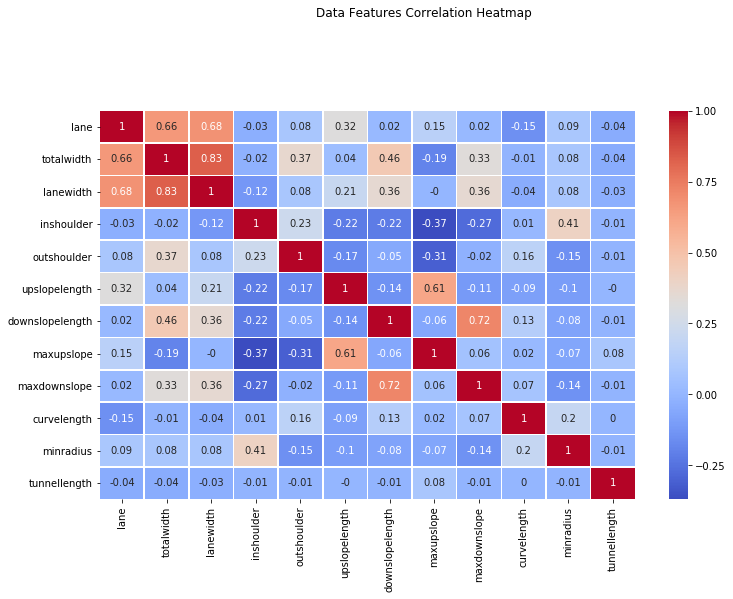

<Figure size 864x864 with 0 Axes>

In [23]:
# draw a heatmap -> roadGeometryRelatedData
corr = roadGeometryRelatedData.corr()
f, ax = plt.subplots(figsize=(12, 8))

plt.figure(figsize=(len(roadGeometryRelatedData.columns), len(roadGeometryRelatedData.columns)))
hm = sns.heatmap(round(corr,2),annot=True, ax=ax, cmap='coolwarm', linewidths=.5)
f.subplots_adjust(top=0.8)
ax.set_ylim(12, 0)
t= f.suptitle('Data Features Correlation Heatmap', fontsize=12)
plt.show() #畫出熱力圖

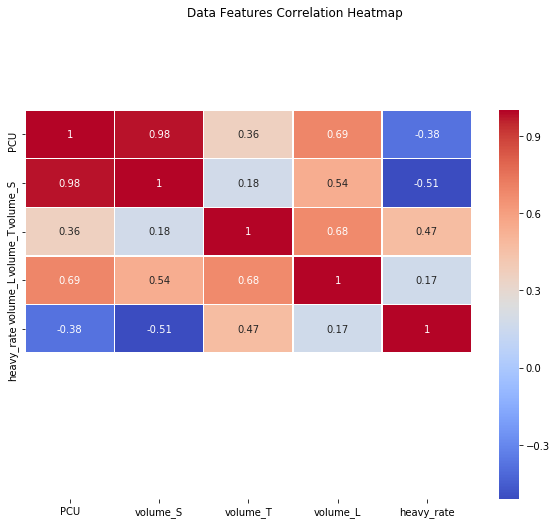

<Figure size 360x360 with 0 Axes>

In [24]:
# draw a heatmap -> trafficRelatedData
corr = trafficFlowRelatedData.corr()
f, ax = plt.subplots(figsize=(10, 8))

plt.figure(figsize=(len(trafficFlowRelatedData.columns), len(trafficFlowRelatedData.columns)))
hm = sns.heatmap(round(corr,2),annot=True, ax=ax, cmap='coolwarm', linewidths=.5)
f.subplots_adjust(top=0.8)
ax.set_ylim(8, 0)
t= f.suptitle('Data Features Correlation Heatmap', fontsize=12)
plt.show() #畫出熱力圖

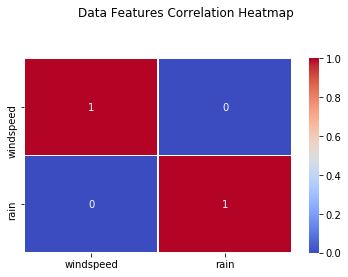

<Figure size 144x144 with 0 Axes>

In [25]:
# draw a heatmap -> trafficRelatedData
corr = weatherRelatedData.corr()
f, ax = plt.subplots(figsize=(6, 4))

plt.figure(figsize=(len(weatherRelatedData.columns), len(weatherRelatedData.columns)))
hm = sns.heatmap(round(corr,2),annot=True, ax=ax, cmap='coolwarm', linewidths=.5)
f.subplots_adjust(top=0.8)
ax.set_ylim(2, 0)
t= f.suptitle('Data Features Correlation Heatmap', fontsize=12)
plt.show() #畫出熱力圖

### by correlation analysis results, 
### we delete #data['Speed_volume'], data['volume_S'], data['volume_L'] and data['volume_T'] 

In [ ]:
data.drop(['Speed_volume', 'volume_S', 'volume_T', 'volume_L'], axis=1, inplace=True)

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
#data_sample = data.sample(n=2000)
data_Y = data['crash']
data_X = data.iloc[:, 1:]

In [ ]:
#convert categorical variable to dummy variable
## all categorial types will automatically convert to categorial variable 
data_X = pd.get_dummies(data_X, columns=None, drop_first=False)

In [ ]:
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=0)

In [ ]:
X_train

In [ ]:
model=sm.Logit(y_train,X_train,random_state=0)
result=model.fit()
print(result.summary())

In [ ]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train,y_train)
#
y_pred=logreg.predict(X_test)

In [ ]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))